# S2RA-regrid-zarr

**Date:** <br>
7 December 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.129:44347,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# load Tgrid zarr

In [9]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.nativeTgrid.zarr',consolidated=True)

In [10]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeUgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.nativeUgrid.zarr',consolidated=True)

In [11]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeVgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.nativeVgrid.zarr',consolidated=True)

# <hr>
# Tgrid - Regridding Step

## curvilinear grid

In [13]:
nav_lon = ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid['lon'].compute()
nav_lat = ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid over chosen region')

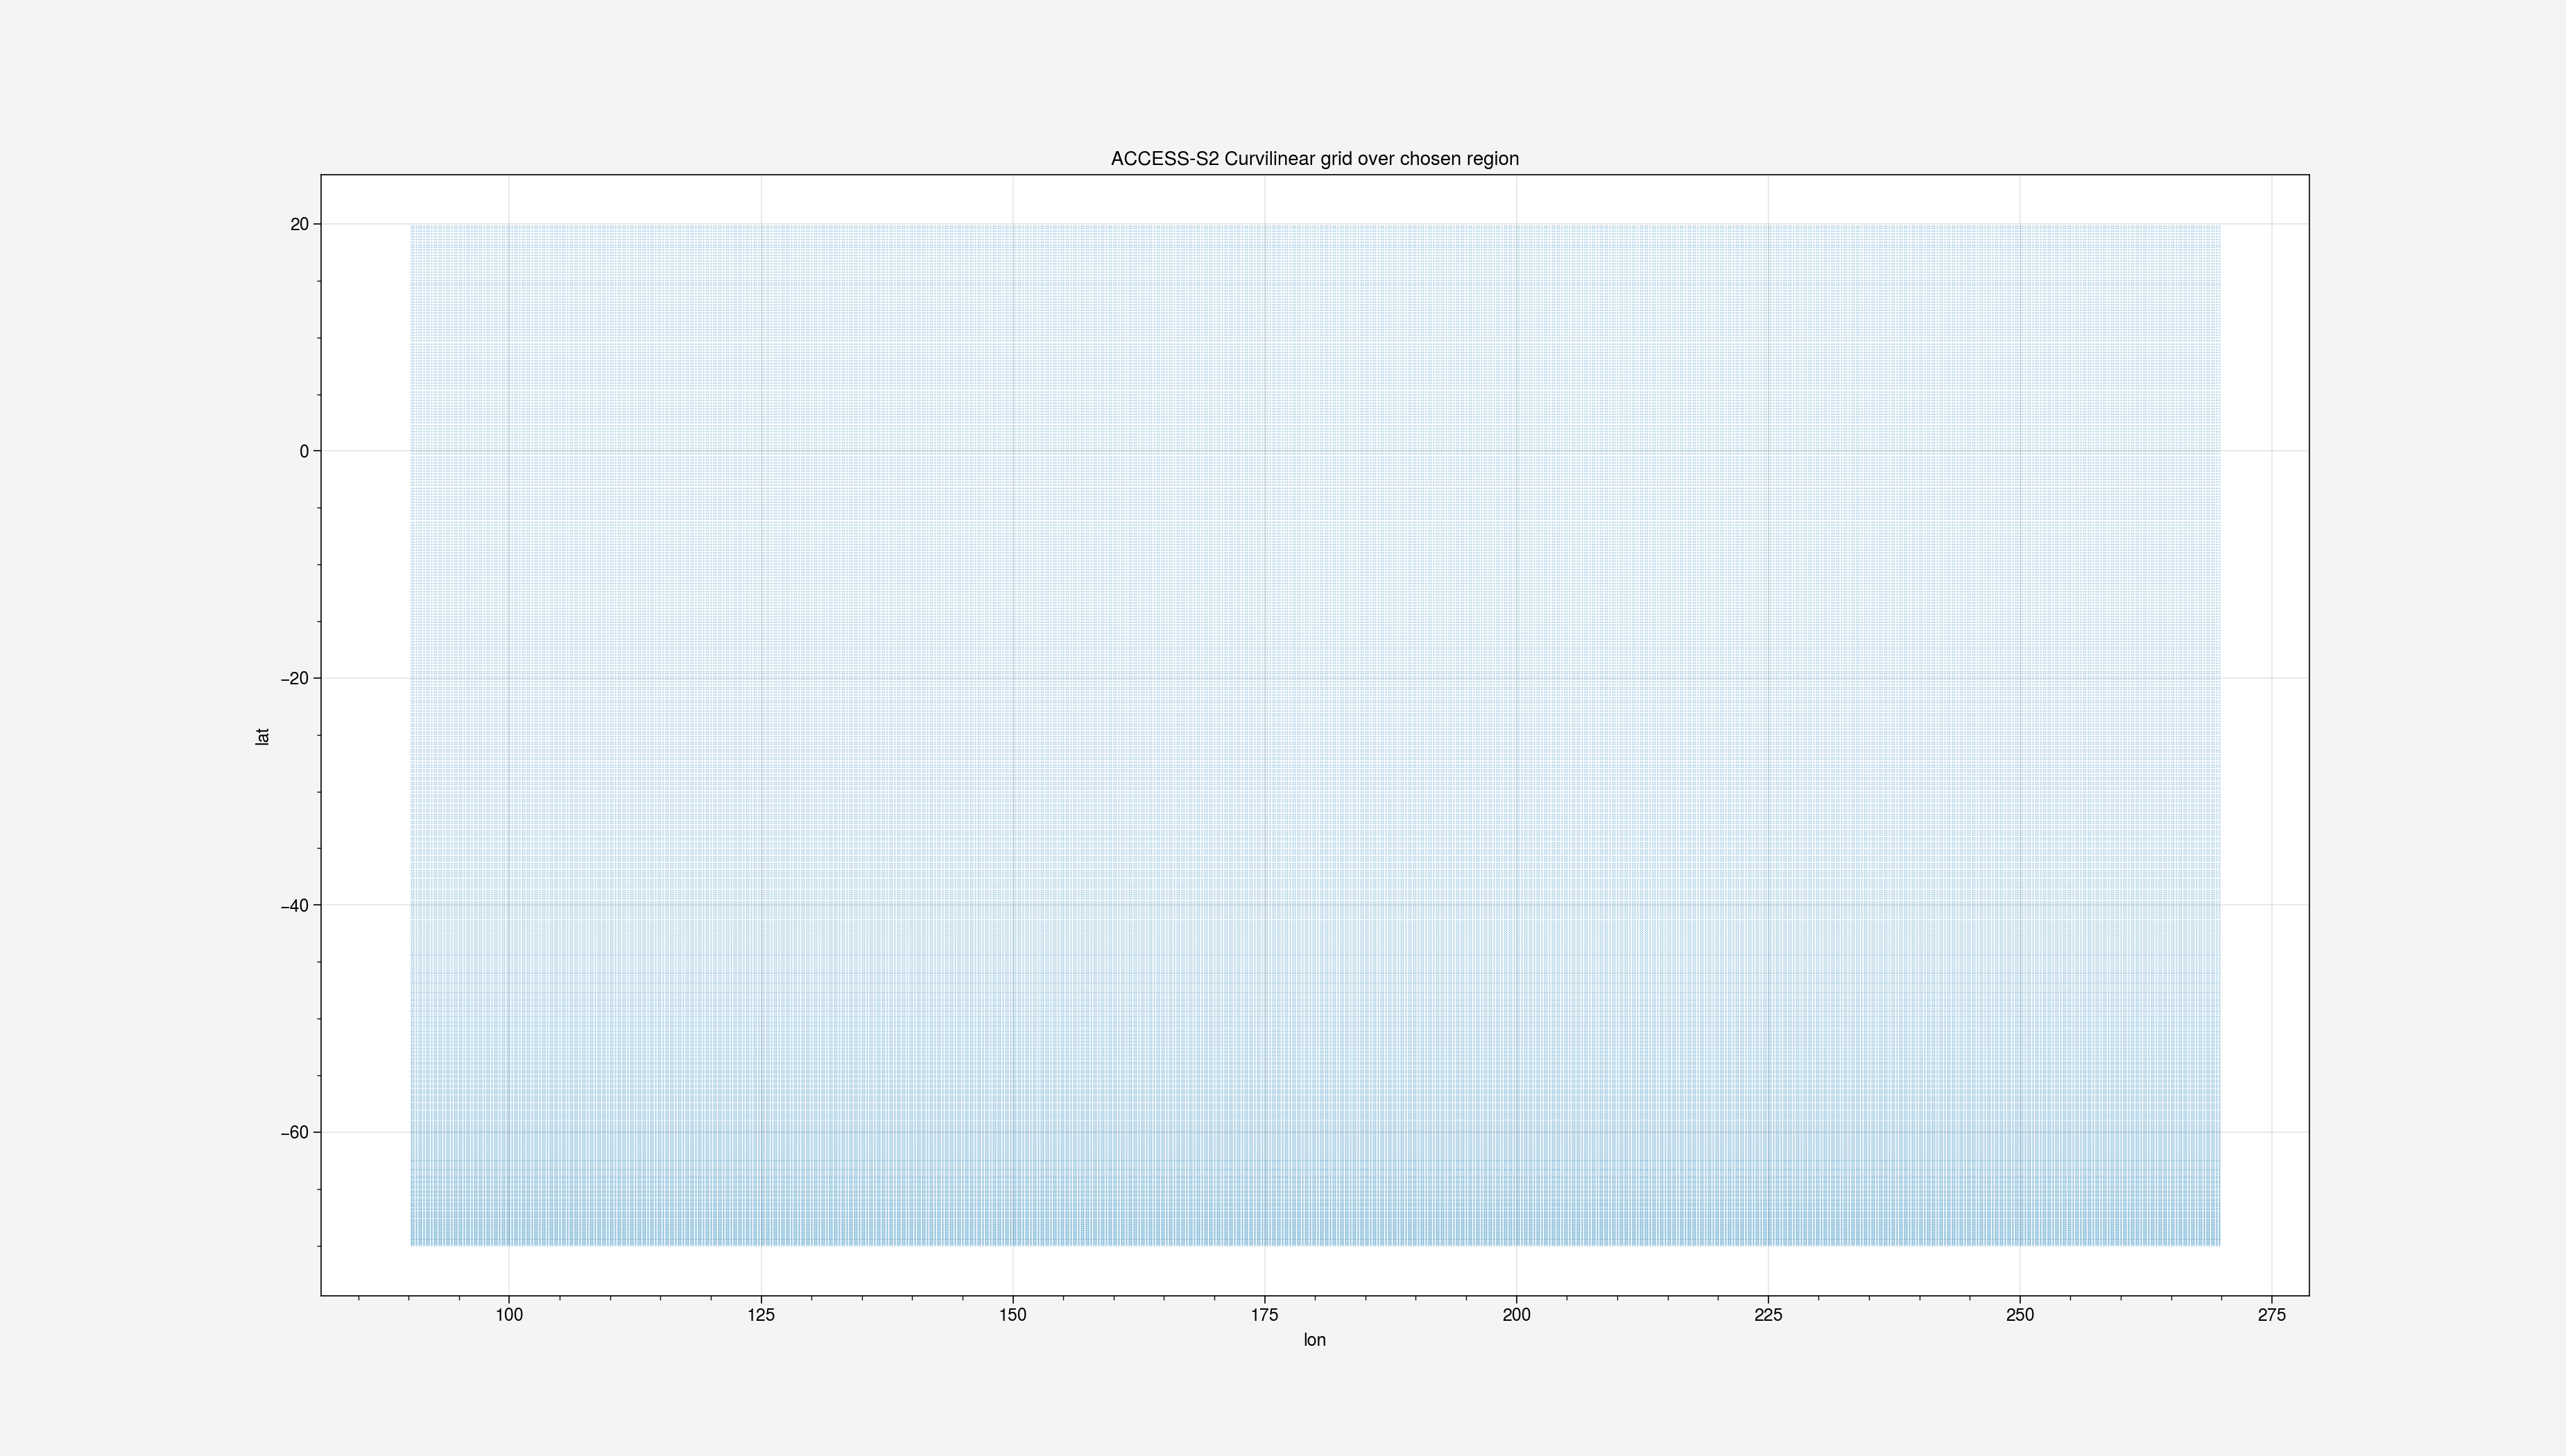

In [16]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid over chosen region')

# Define new 0.25 degree grid

In [50]:
new_025deg_grid = xe.util.grid_2d(
    90, 270, 0.25, -70, 20, 0.25  # longitude range and resolution
)  # latitude range and resolution
new_025deg_grid

<xarray.Dataset>
Dimensions:  (y: 360, x: 720, y_b: 361, x_b: 721)
Coordinates:
    lon      (y, x) float64 90.12 90.38 90.62 90.88 ... 269.1 269.4 269.6 269.9
    lat      (y, x) float64 -69.88 -69.88 -69.88 -69.88 ... 19.88 19.88 19.88
    lon_b    (y_b, x_b) float64 90.0 90.25 90.5 90.75 ... 269.5 269.8 270.0
    lat_b    (y_b, x_b) float64 -70.0 -70.0 -70.0 -70.0 ... 20.0 20.0 20.0 20.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [44]:
def extend_S2_lon_across180(real_lon):
    '''
    extend_S2_lon_across180
    Notes: ACCESS-S2 runs from left to right 72.75 to 73 through 180/-180. For this specific application we are trying to bridge the 180/-180 date
        line with increasing values.  This is simply to use a .where technique to slice the mulitdimensional coordinates over the Pacific.
    Returns: 
    Defaults:
    Author: Thomas Moore
    Date created: 21/02/2022
    Assumptions:
    Use:
    Limitations:
    '''
    return (real_lon % 360)

In [37]:
new_025deg_grid['lon'] = extend_S2_lon_across180(new_025deg_grid['lon'])
new_025deg_grid['lon_b'] = extend_S2_lon_across180(new_025deg_grid['lon_b'])

In [38]:
new_025deg_grid

<xarray.Dataset>
Dimensions:  (y: 720, x: 1440, y_b: 721, x_b: 1441)
Coordinates:
    lon      (y, x) float64 180.1 180.4 180.6 180.9 ... 179.1 179.4 179.6 179.9
    lat      (y, x) float64 -89.88 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    lon_b    (y_b, x_b) float64 180.0 180.2 180.5 180.8 ... 179.5 179.8 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

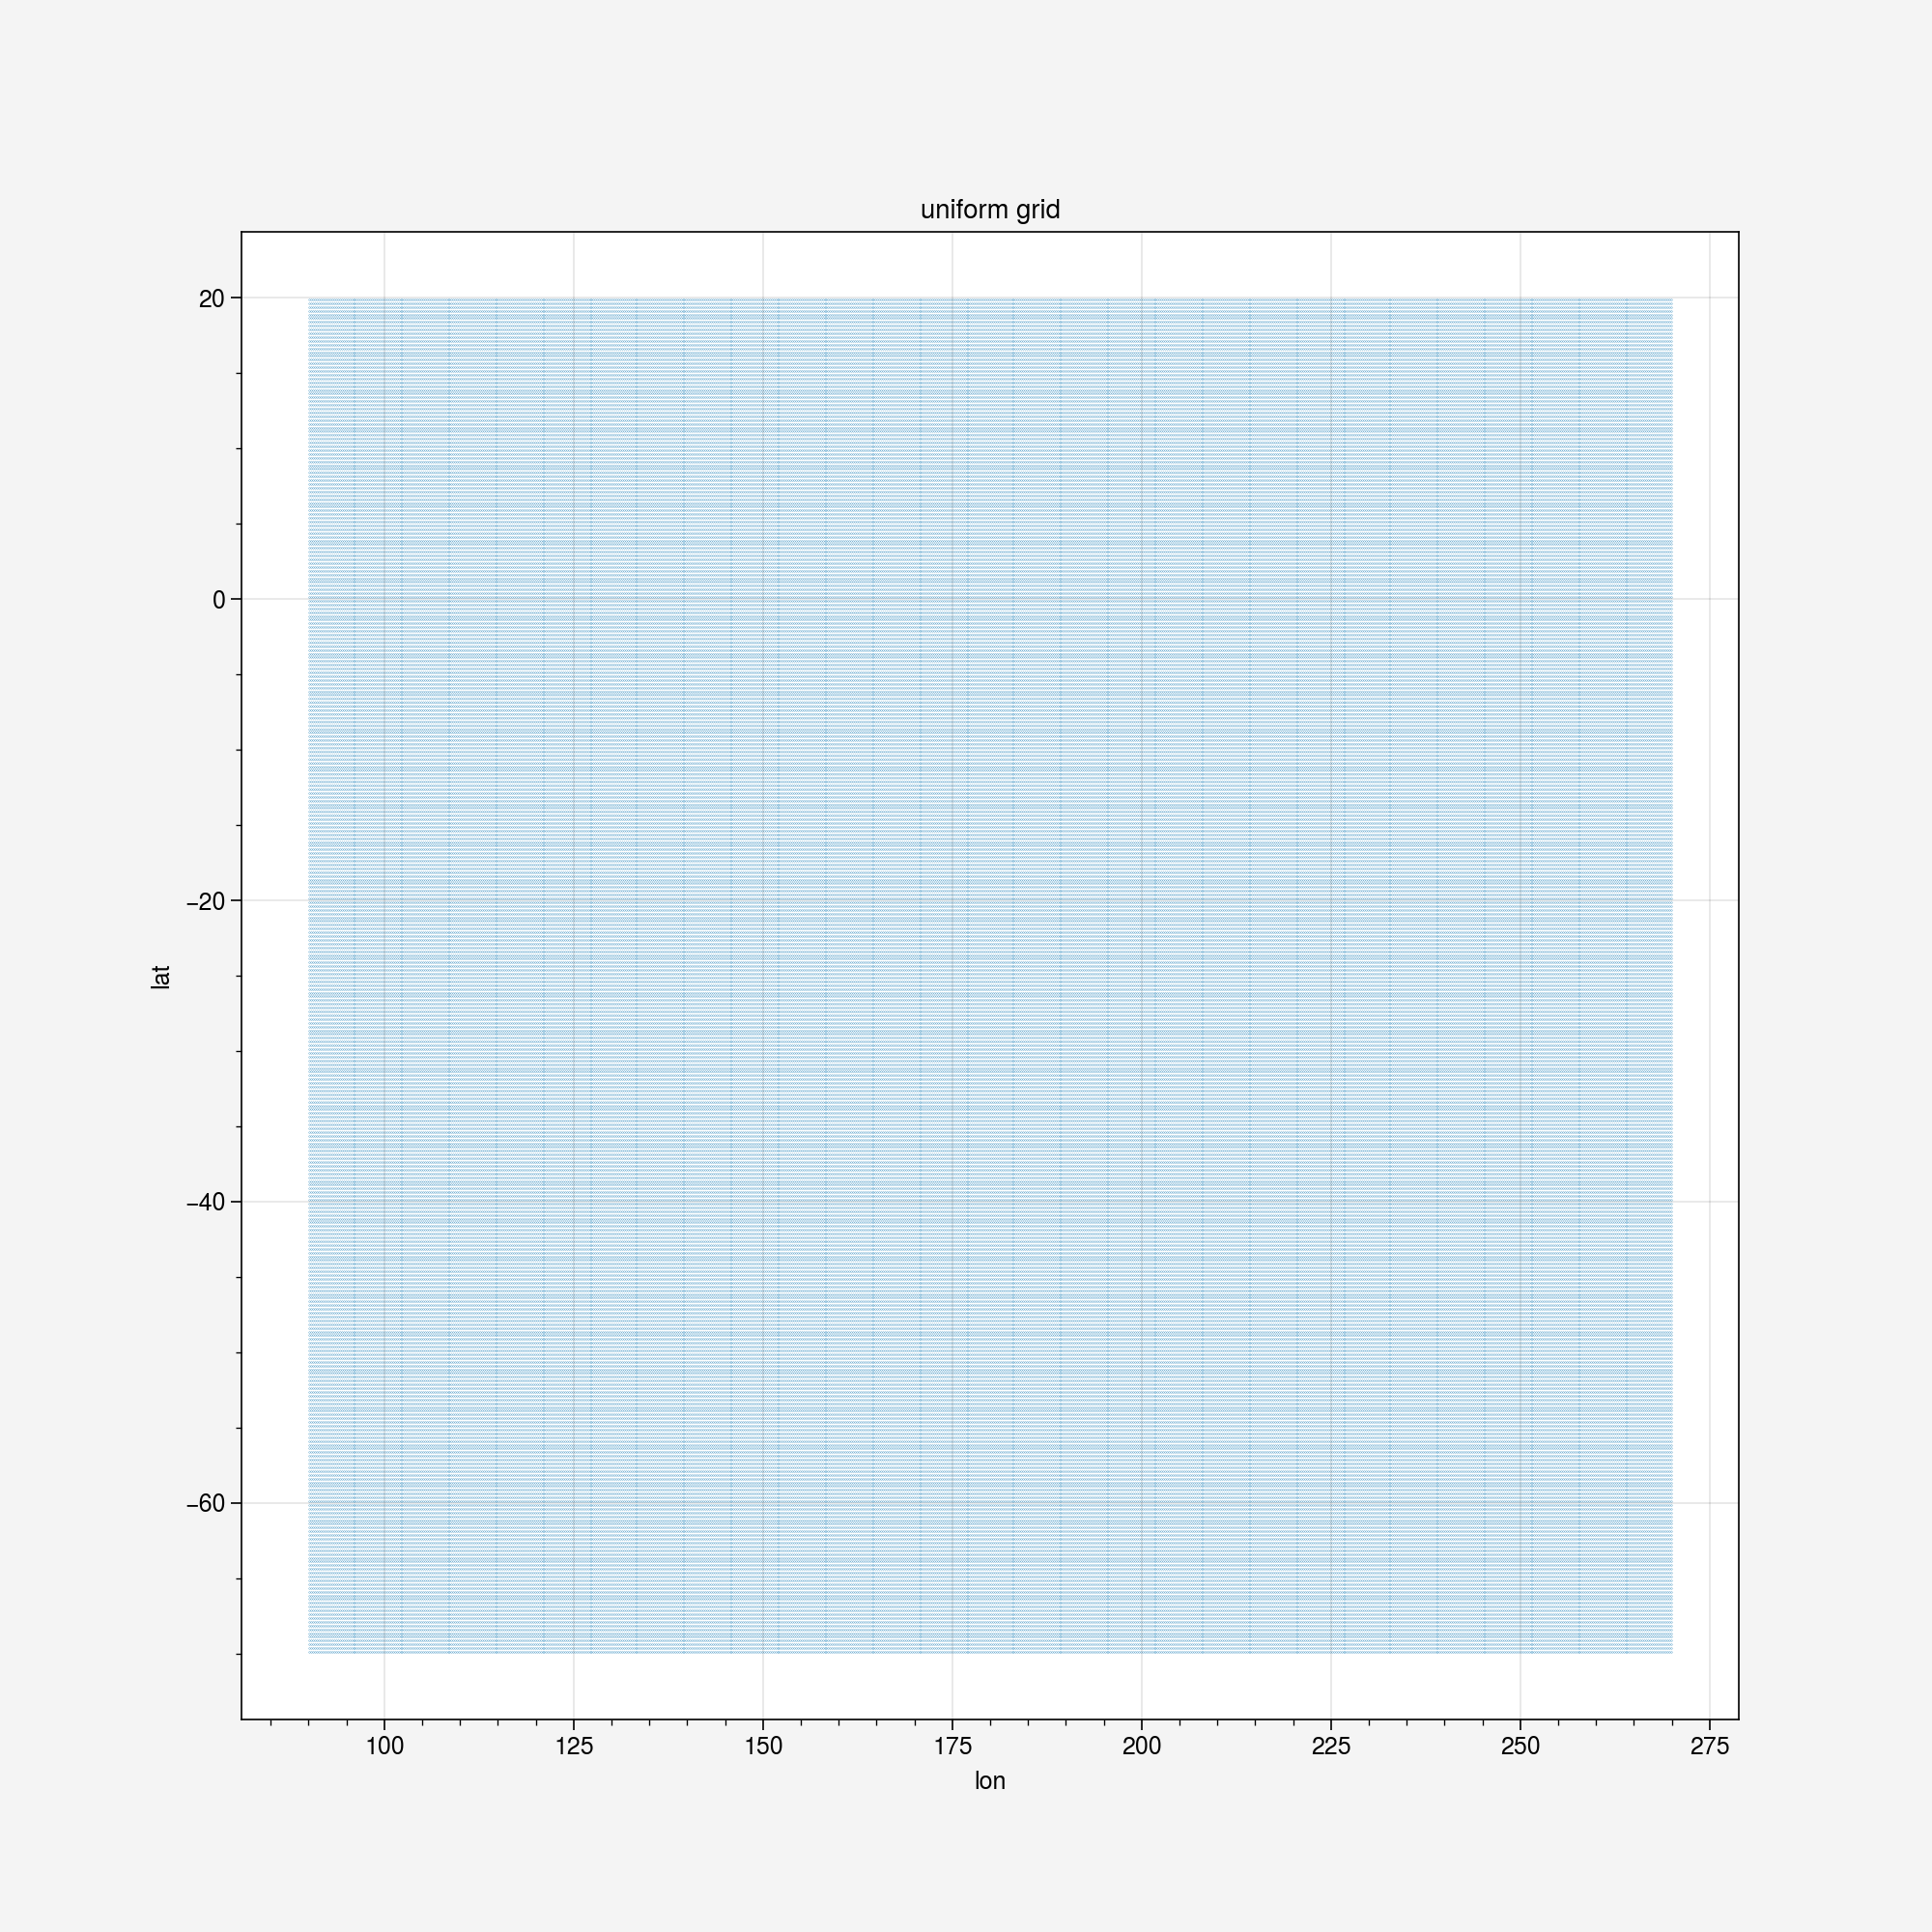

In [51]:
plt.scatter(new_025deg_grid.lon, new_025deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [55]:
%%time
regridder_S2_025deg_Tgrid = xe.Regridder(ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid, new_025deg_grid, method='bilinear', reuse_weights=False)

CPU times: user 12.7 s, sys: 949 ms, total: 13.7 s
Wall time: 13.3 s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [56]:
%%time
regridder_S2_025deg_Tgrid._grid_in = None
regridder_S2_025deg_Tgrid._grid_out = None
ds_S2_RA_ocean_masked_AUSWCPregion_025grid = regridder_S2_025deg_Tgrid(ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid)

CPU times: user 4.26 s, sys: 238 ms, total: 4.5 s
Wall time: 5.45 s


# rename the coordinates to drop the x/y now that we are rectilinear

In [60]:
ds_S2_RA_ocean_masked_AUSWCPregion_025grid = ds_S2_RA_ocean_masked_AUSWCPregion_025grid.assign_coords({
    'x': ds_S2_RA_ocean_masked_AUSWCPregion_025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_025grid.lat.isel(x=0)
    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [61]:
ds_S2_RA_ocean_masked_AUSWCPregion_025grid

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
  * lon      (lon) float64 90.12 90.38 90.62 90.88 ... 269.1 269.4 269.6 269.9
  * lat      (lat) float64 -69.88 -69.62 -69.38 -69.12 ... 19.38 19.62 19.88
Data variables: (12/13)
    areat    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ssh      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ...       ...
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# plot up an SST timeslice for this unmasked regrid to 0.25

In [69]:
SST_unmasked = ds_S2_RA_ocean_masked_AUSWCPregion_025grid.sst.isel({'time':300}).compute()

(120.0, 160.0)

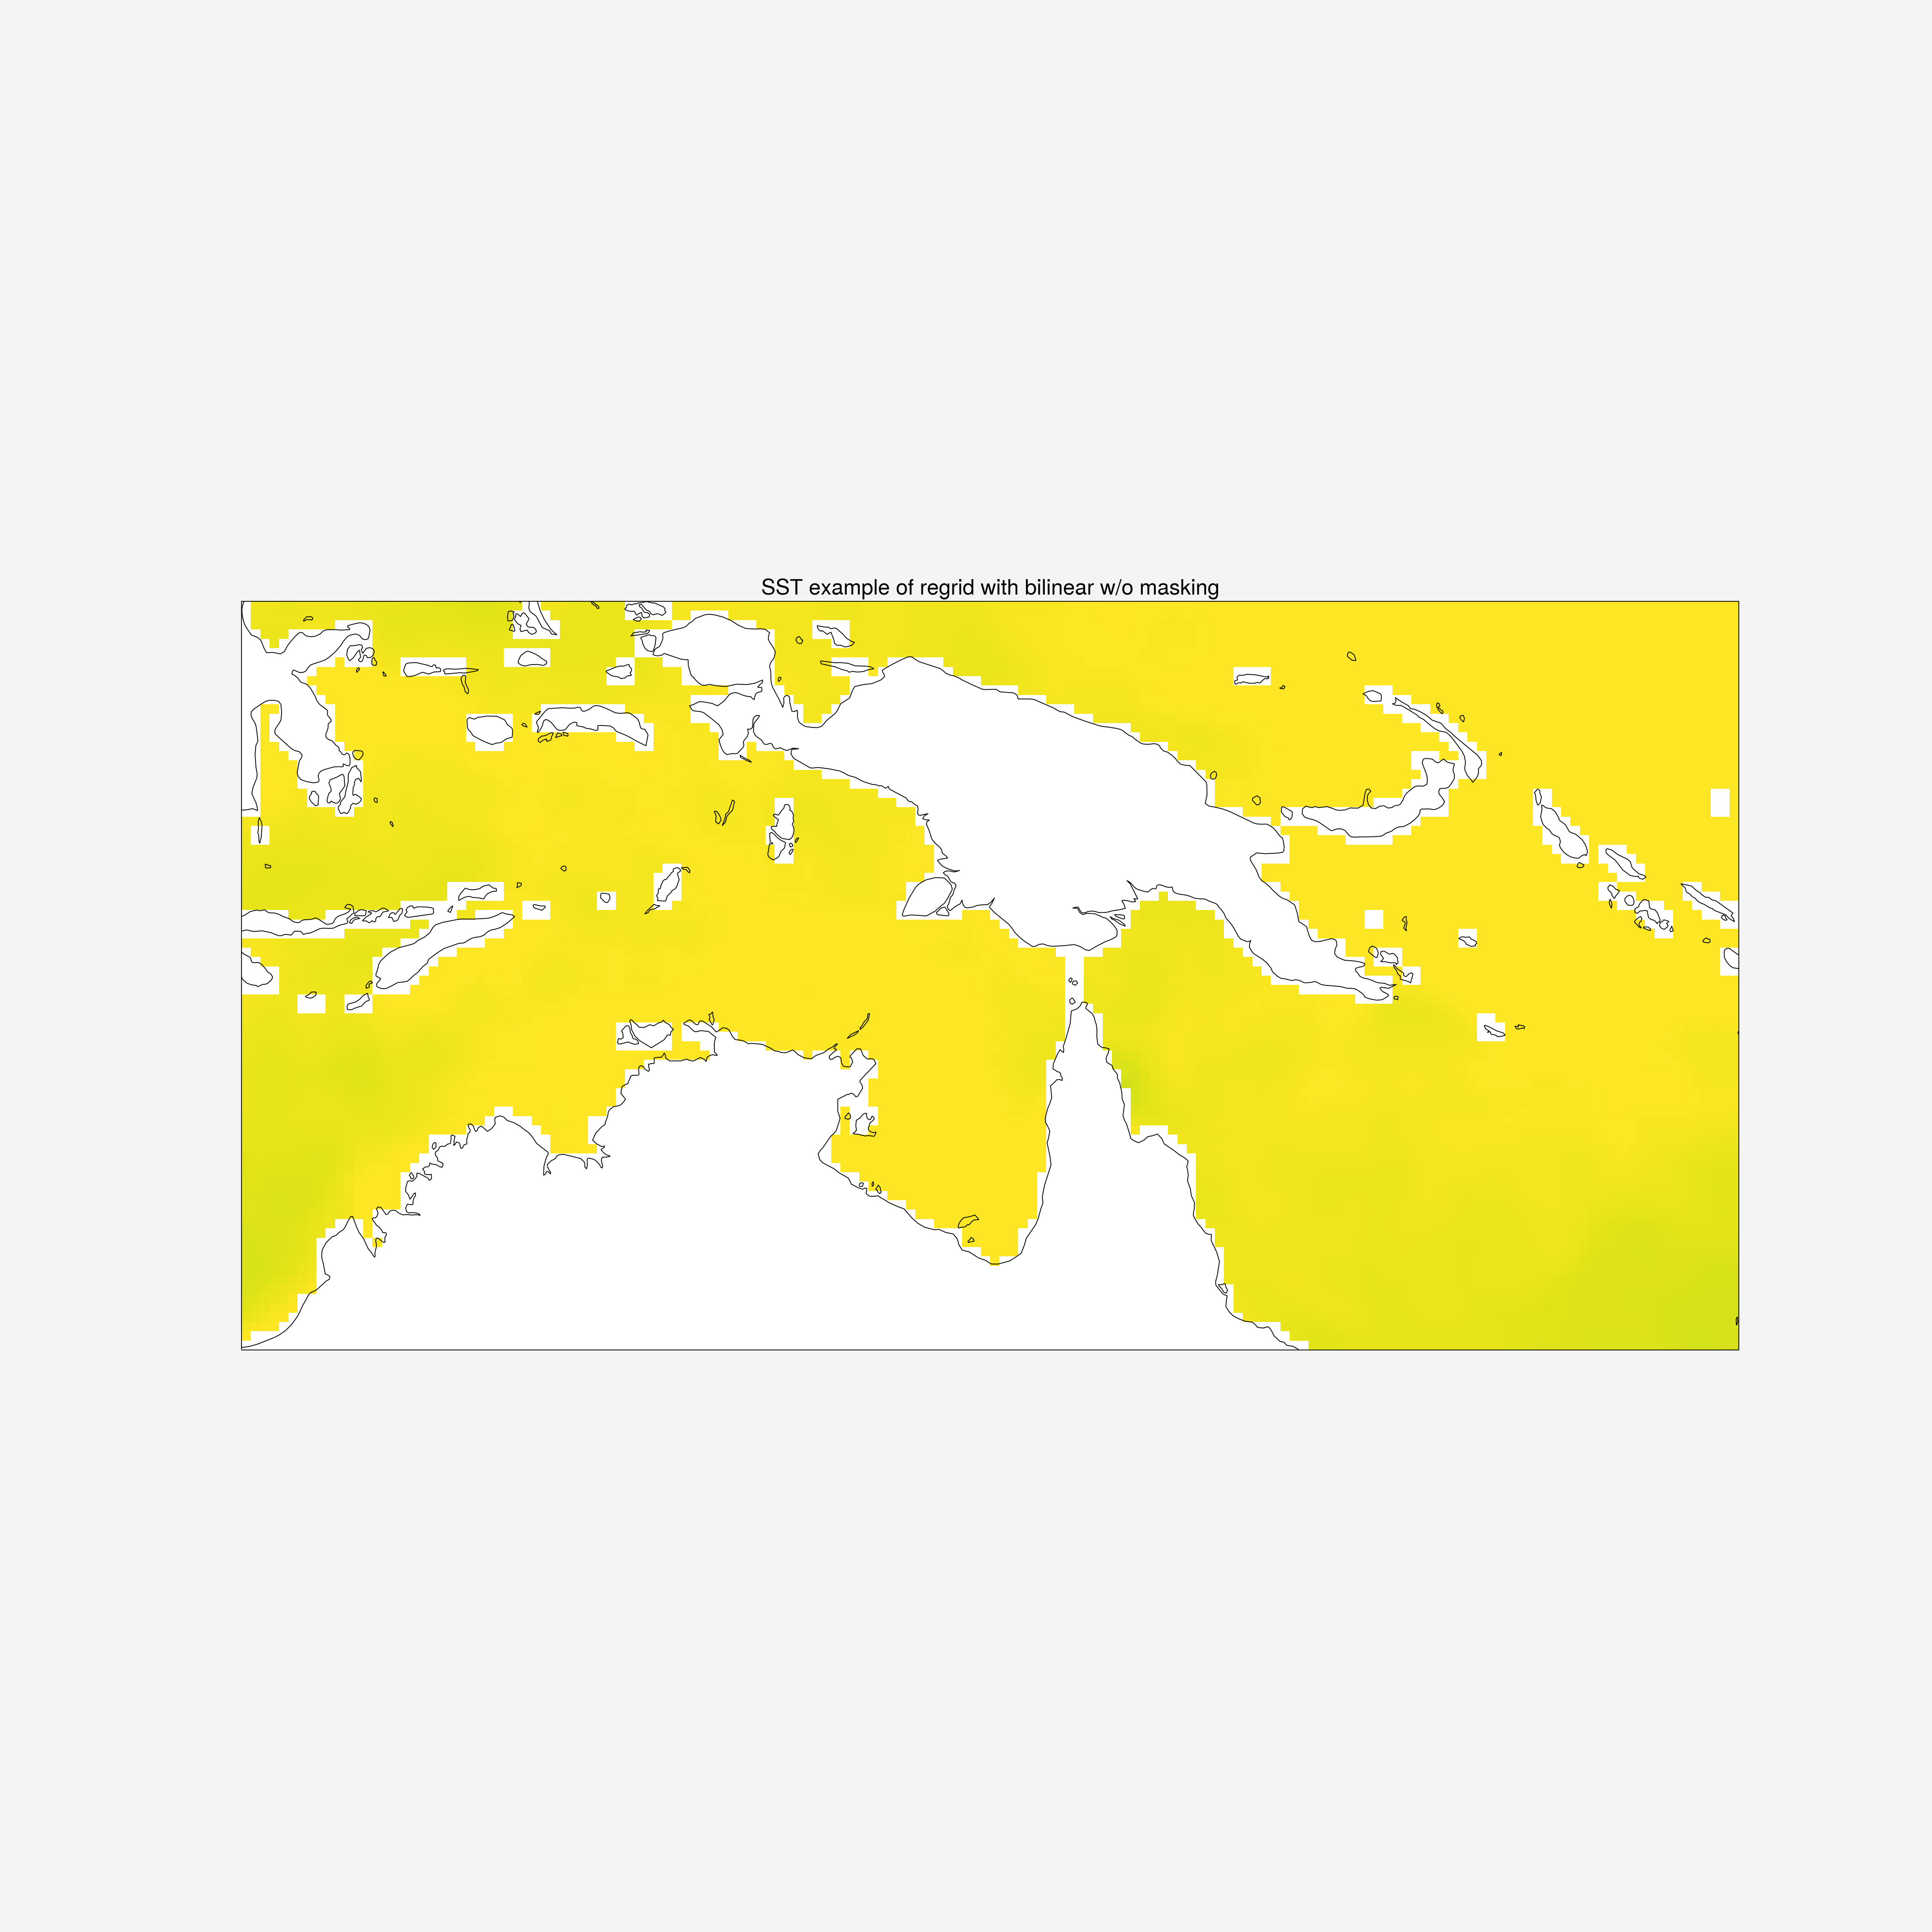

In [101]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
SST_unmasked.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=0.3, add_colorbar=False
)
ax.set_title('SST example of regrid with bilinear w/o masking', fontsize=16)
ax.coastlines()
ax.set_ylim([-20, 0])
ax.set_xlim([120, 160])

# plot up an temp500 timeslice for this unmasked regrid to 0.25

In [102]:
temp500_unmasked = ds_S2_RA_ocean_masked_AUSWCPregion_025grid.temp500.isel({'time':300}).compute()

(120.0, 160.0)

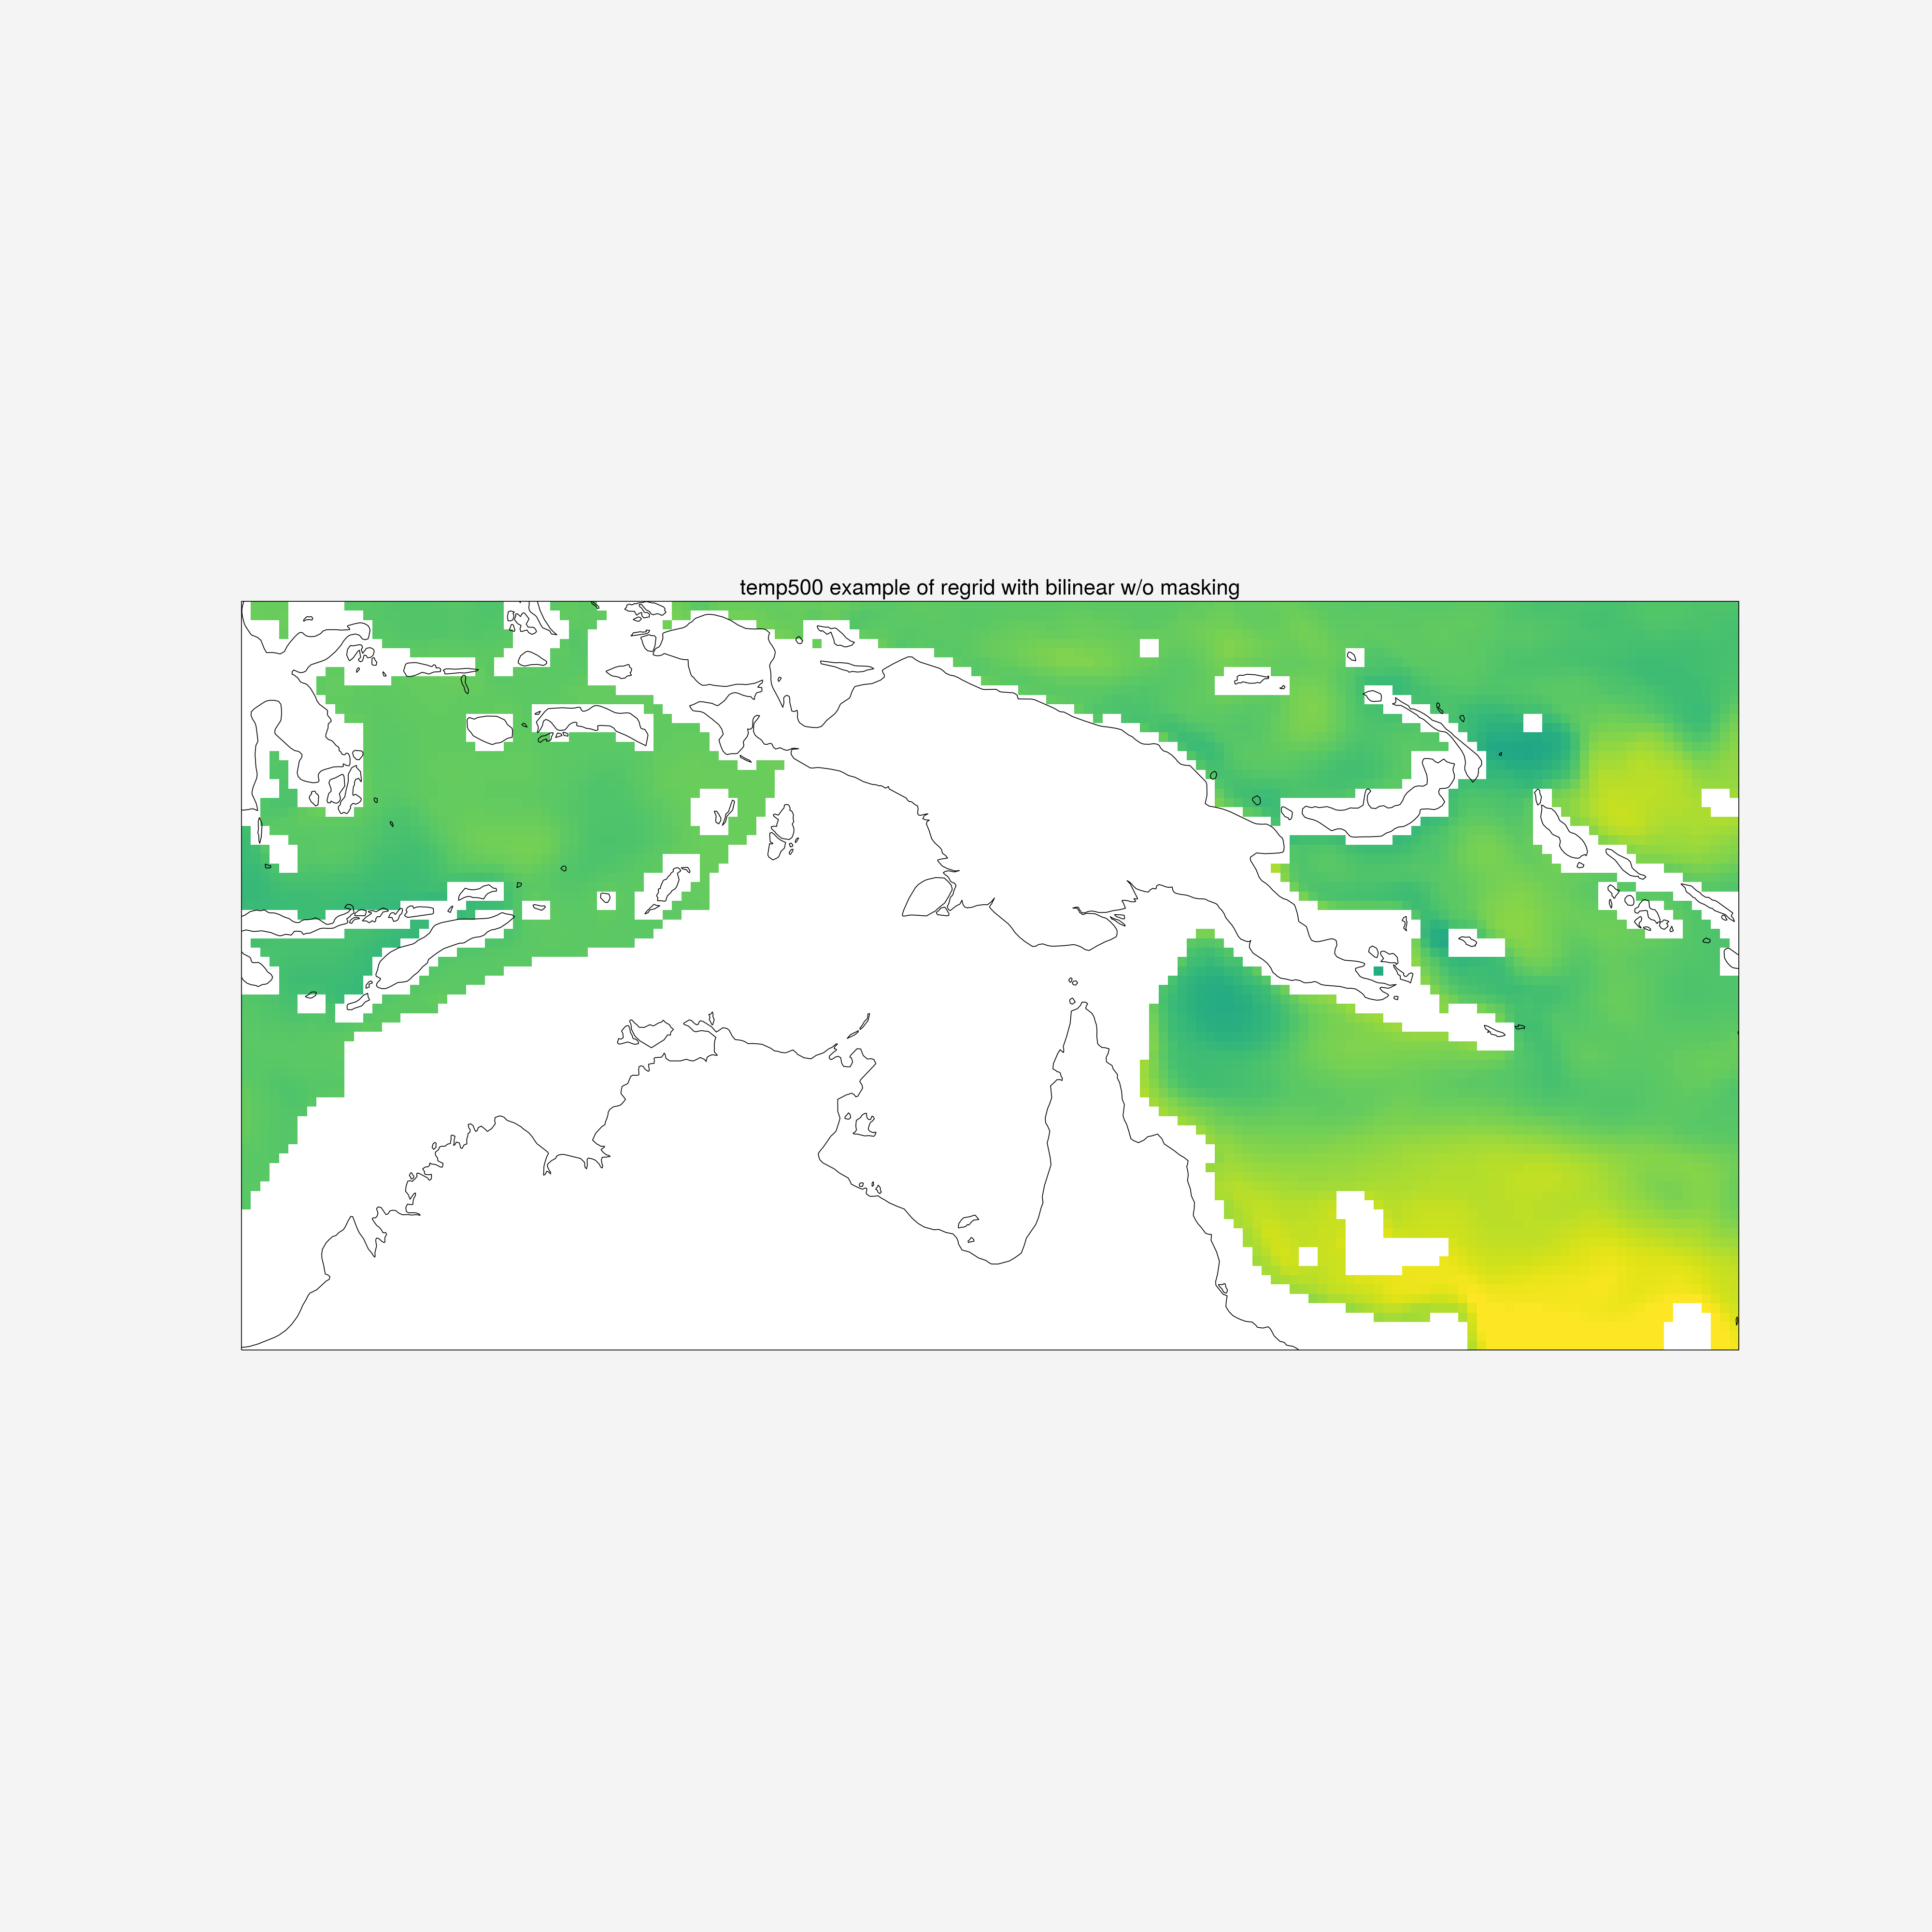

In [103]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
temp500_unmasked.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=0.3, add_colorbar=False
)
ax.set_title('temp500 example of regrid with bilinear w/o masking', fontsize=16)
ax.coastlines()
ax.set_ylim([-20, 0])
ax.set_xlim([120, 160])

In [ ]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_S2_RA_ocean_masked_AUSWCPregion_025grid.sst.isel({'time':300}).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False
)
ax.coastlines()
ax.set_ylim([-80, 30])
ax.set_xlim([90, 300])

# Try bilinear with a mask

In [96]:
ds_ACCESS_S2_RA_ocean_1degRegrid = ds_ACCESS_S2_RA_ocean_1degRegrid.assign_coords({'x': ds_ACCESS_S2_RA_ocean_1degRegrid.lon.isel(y=0),'y': ds_ACCESS_S2_RA_ocean_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [97]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2020-12-01
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areat    (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [98]:
ds_ACCESS_S2_RA_ocean_1degRegrid.nbytes/1e9

1.36884336

## Sanity check

In [99]:
%%time
regrid_data = ds_ACCESS_S2_RA_ocean_1degRegrid.mld1.mean(dim='time').compute()
coarsened_data = ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

CPU times: user 2.55 s, sys: 571 ms, total: 3.12 s
Wall time: 14 s


CPU times: user 231 ms, sys: 16.8 ms, total: 248 ms
Wall time: 239 ms


(36.0, 107.0)

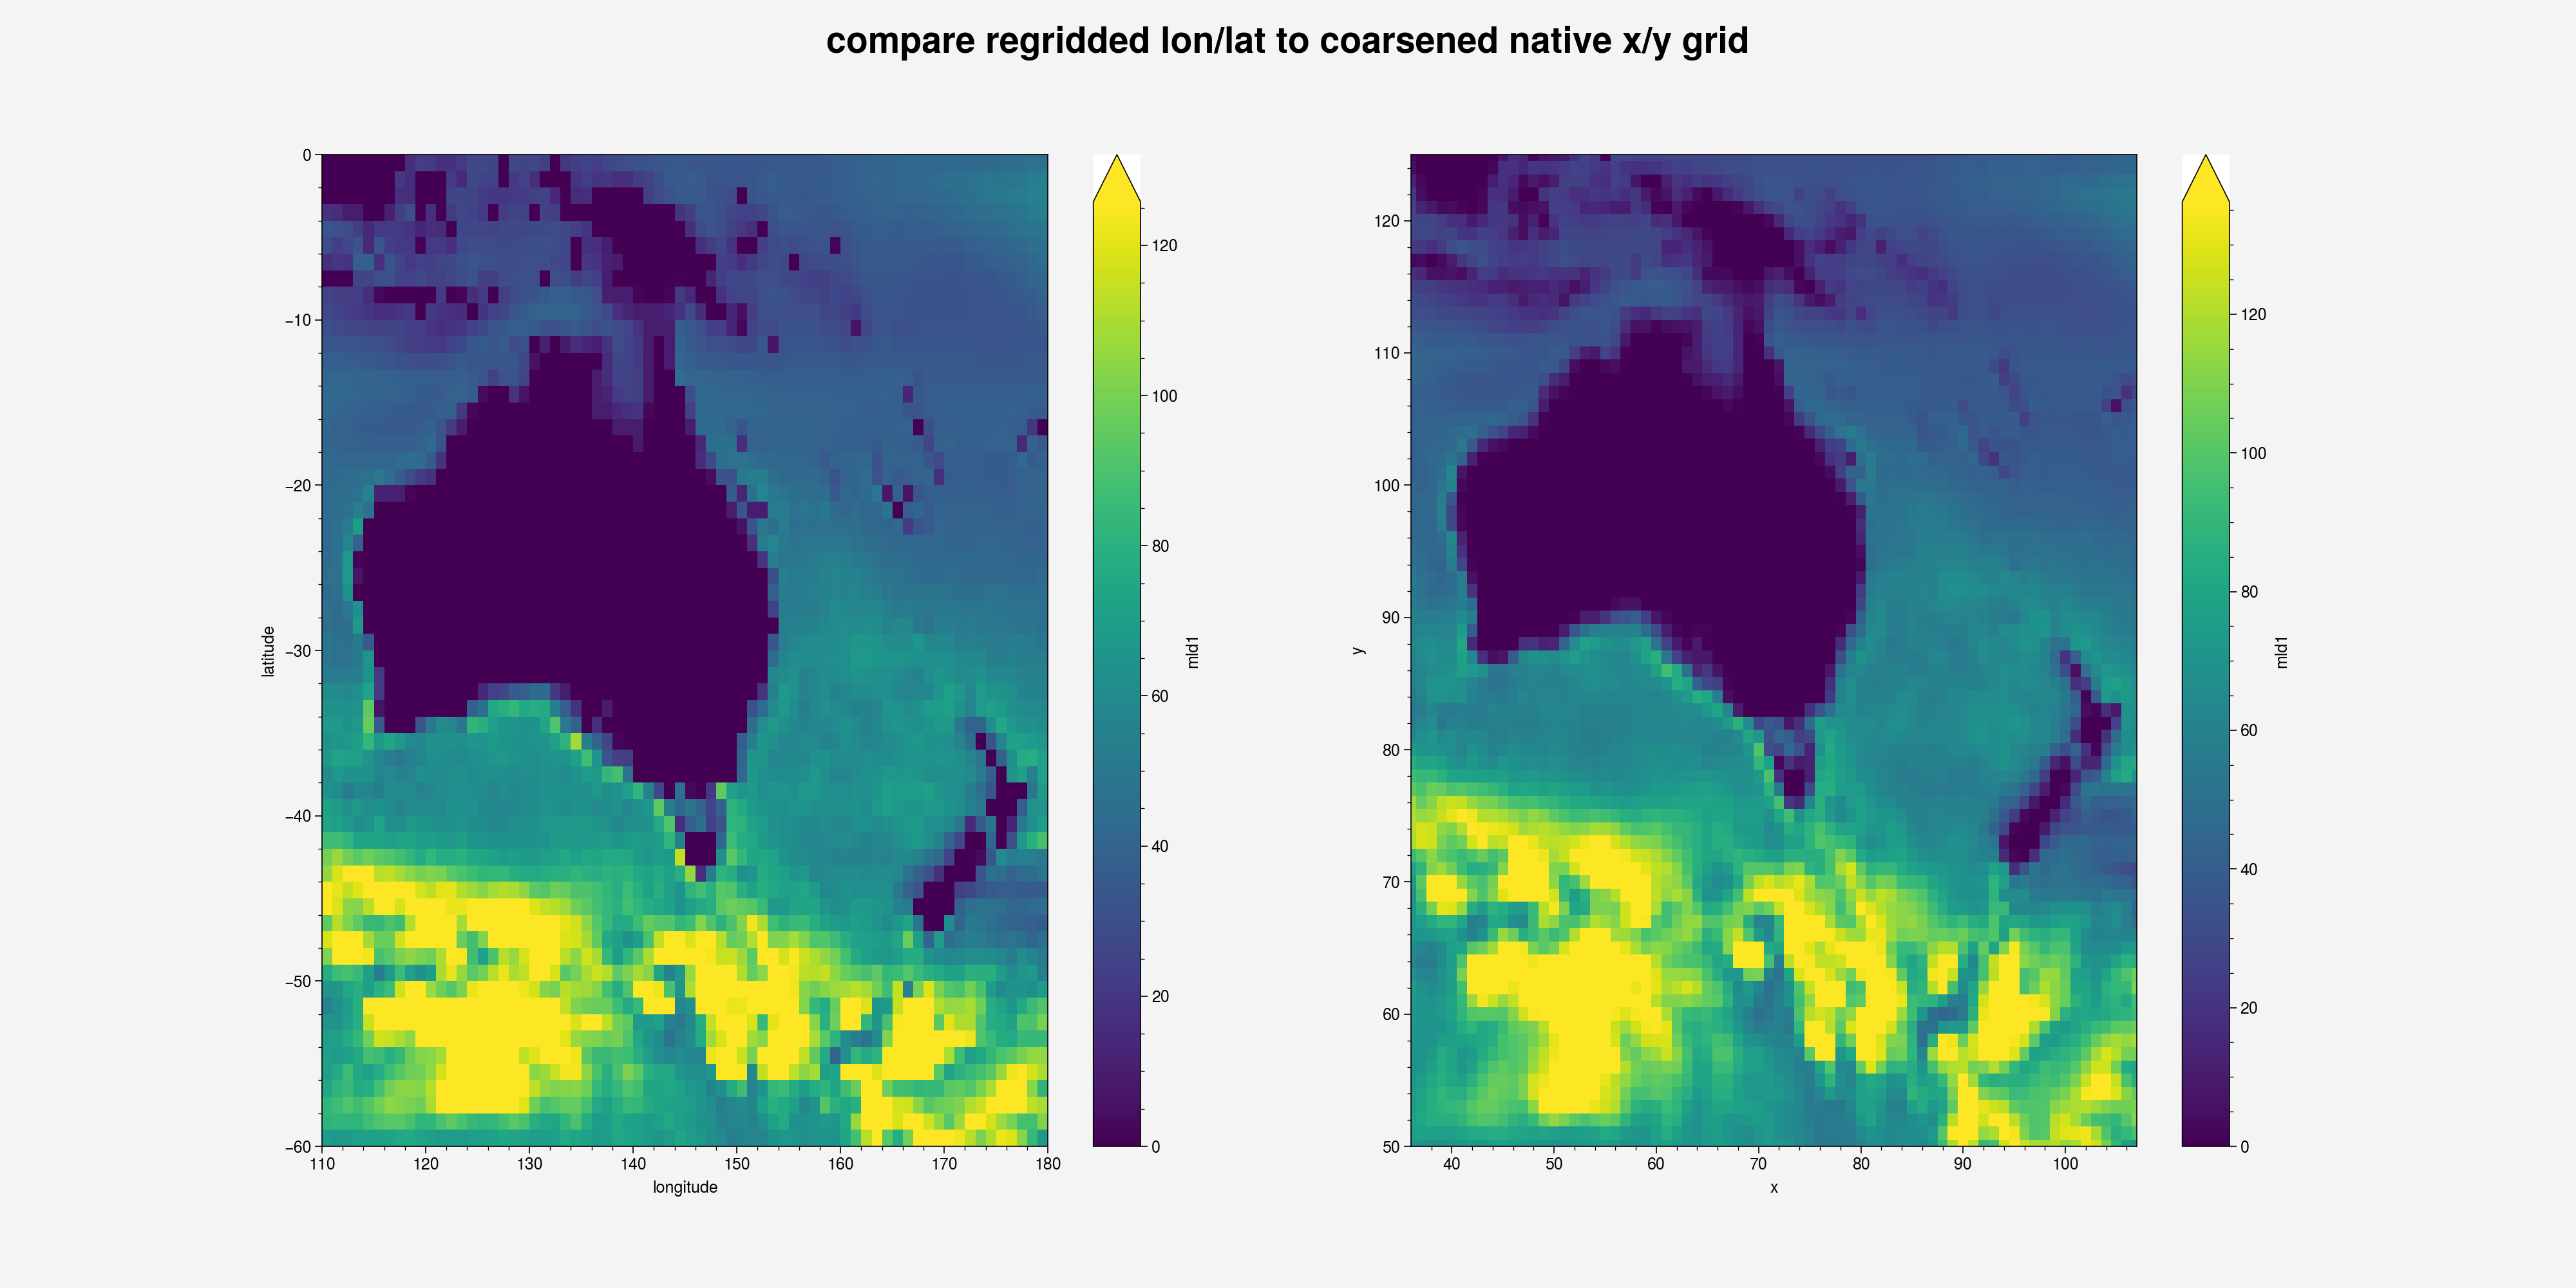

In [100]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [101]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2020-12-01
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areat    (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [8]:
%%time
ds_ACCESS_S2_RA_ocean_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

NameError: name 'ds_ACCESS_S2_RA_ocean_1degRegrid' is not defined

# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [10]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u

CPU times: user 6.43 s, sys: 1.75 s, total: 8.18 s
Wall time: 29.7 s


<xarray.Dataset>
Dimensions:            (depthu: 75, y: 1021, x: 1442, time_counter: 480, tbnds: 2)
Coordinates:
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time_counter, depthu, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [11]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v

CPU times: user 4.88 s, sys: 1.11 s, total: 5.99 s
Wall time: 14.6 s


<xarray.Dataset>
Dimensions:            (depthv: 75, y: 1021, x: 1442, time_counter: 480, tbnds: 2)
Coordinates:
  * depthv             (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time_counter, depthv, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# Deal with the same depth coordinates given two different names & rename time

In [12]:
ds_u = ds_u.rename({'depthu':'depth','time_counter':'time'})
ds_v = ds_v.rename({'depthv':'depth','time_counter':'time'})

# Deal with inconsistant and crazy dates (use time from Tgrid zarr already corrected)

In [15]:
new_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time

In [16]:
ds_u['time'] = new_time
ds_v['time'] = new_time

In [17]:
ds_u

<xarray.Dataset>
Dimensions:            (depth: 75, y: 1021, x: 1442, time: 480, tbnds: 2)
Coordinates:
  * depth              (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time               (time) datetime64[ns] 1981-01-16 ... 2020-12-01
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

# Double Check for bugged time stamps

In [18]:
u_time = ds_u.time.values
v_time = ds_v.time.values
ds_ACCESS_S2_RA_ocean_nativeTgrid_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time.values

In [19]:
compare_UV = (u_time == v_time)
np.where(compare_UV==False)

(array([], dtype=int64),)

In [20]:
u_time[236]

numpy.datetime64('2000-09-16T00:00:00.000000000')

In [21]:
v_time[236]

numpy.datetime64('2000-09-16T00:00:00.000000000')

In [22]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[236]

numpy.datetime64('2000-09-16T00:00:00.000000000')

In [23]:
u_time[329]

numpy.datetime64('2008-06-16T00:00:00.000000000')

In [24]:
v_time[329]

numpy.datetime64('2008-06-16T00:00:00.000000000')

In [25]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[329]

numpy.datetime64('2008-06-16T00:00:00.000000000')

# Checks out

# re-chunk with rechunker!
# and write out native grid U & V zarr collections

In [26]:
ds_u = ds_u[['u']]
# not sure this encoding reset is needed #
for var in ds_u.variables:
        ds_u[var].encoding = {}

In [27]:
ds_u

<xarray.Dataset>
Dimensions:  (time: 480, depth: 75, y: 1021, x: 1442)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat  (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2020-12-01
Dimensions without coordinates: y, x
Data variables:
    u        (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [28]:
%%time
target_chunks = {
        'u': {'time':480,'depth':1,'x':250,'y':250},
        'time': None,
        'depth': None}

mem_max = '20GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_u, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.u.chunks))
ds_u_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

final chunking scheme:(480, 1, 250, 250)
CPU times: user 1min 28s, sys: 9.45 s, total: 1min 37s
Wall time: 9min 32s


In [33]:
ds_v = ds_v[['v']]
# not sure this encoding reset is needed #
for var in ds_v.variables:
        ds_v[var].encoding = {}

In [34]:
%%time
target_chunks = {
        'v': {'time':480,'depth':1,'x':250,'y':250},
        'time': None,
        'depth': None}

mem_max = '20GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_v, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.v.chunks))
ds_v_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr
ds_v_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',
                                         consolidated=True)

final chunking scheme:(480, 1, 250, 250)
CPU times: user 1min 31s, sys: 9.92 s, total: 1min 41s
Wall time: 9min 58s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [6]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)

In [7]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [8]:
u_da = u.u
v_da = v.v

In [9]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

CPU times: user 7.95 s, sys: 1.74 s, total: 9.69 s
Wall time: 1min 9s


In [10]:
KE = xr.merge([EKE,MKE])

In [11]:
KE

,Array,Chunk
Bytes,197.45 GiB,114.44 MiB
Shape,"(480, 75, 1021, 1442)","(480, 1, 250, 250)"
Count,31502 Tasks,2250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,421.22 MiB,244.14 kiB
Shape,"(75, 1021, 1442)","(1, 250, 250)"
Count,22502 Tasks,2250 Chunks
Type,float32,numpy.ndarray


In [42]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)

CPU times: user 2min 2s, sys: 10.8 s, total: 2min 13s
Wall time: 3min 50s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [43]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)

In [44]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [45]:
KE_surface = KE.isel(depth=0).compute()

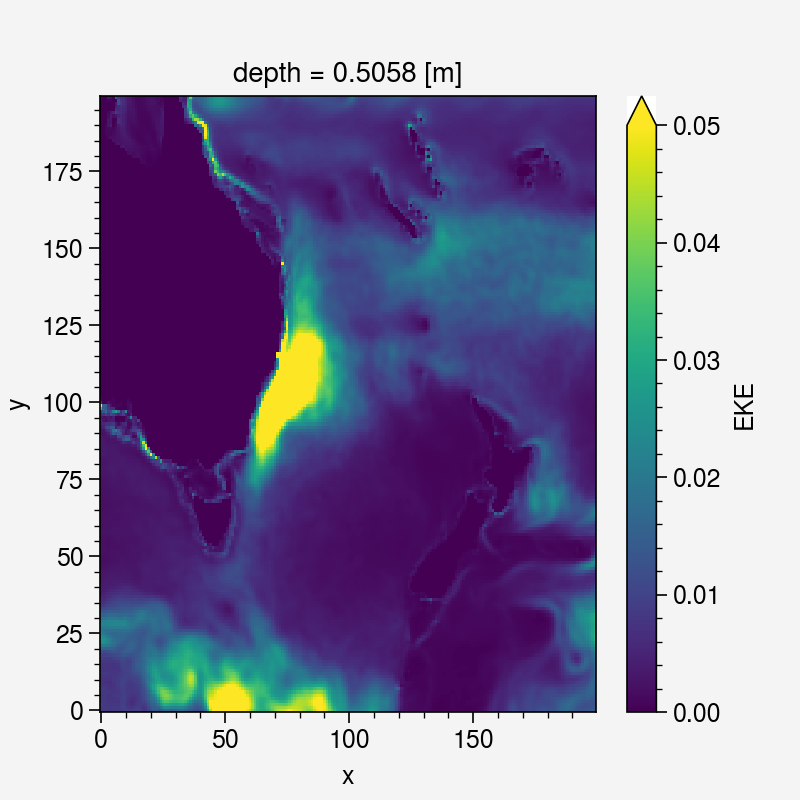

In [46]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7fcb04415430>>, <Task finished name='Task-304880' coro=<Scheduler.restart() done, defined at /g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/scheduler.py:5885> exception=CommClosedError("Exception while trying to call remote method 'restart' before comm was established.")>)
Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/core.py", line 819, in send_recv_from_rpc
    result = awa

In [47]:
client.shutdown()

In [ ]:
client.restart()